# Week 9. Post-Earnings Announcement Drift (PEAD)

In this section, we focus on one particular example of event studies, that is, post-earnings announcement drift (PEAD). 

### Background

* Every quarter, a firm announces its earnings (e.g., earnings-per-share or EPS).  <br>
<br>
* Before the announcement of quarterly earnings, market participants (professional analysts, retail investors, etc.) have specific expectations on the EPS.   <br>
<br>
* Question: Suppose that a firm's realised EPS beats its prior expectation, what is the drift in its stock price in the subsequent trading days? How about the price reaction to the underperformance in EPS? 
   * For example, if everyone expects the EPS of AAPL to be $\$2$ per quarter. The realised EPS is instead $\$3$, which is significantly higher than the expected value. Do we tend to observe that the stock price increases or decreases in the next 50 trading days after the earnings announcement? 

**Rendleman, Jones, and Latane (1982)** study the abnormal returns for a large sample of firms around and after earnings announcements. 
* They sort all firms into 10 groups according to the magnitude of earnings surprises (realised minus expected EPS).
* On the day of an announcement, the abnormal return seems to positively correlate with the earning surprises.
* Moreover, stock prices continue to drift in the same direction for many trading days: Stock markets are not efficient enough since the new information (earnings surprises) is slowly incorporated in stock prices.
* One potential explanation is that investors underreact to the information in earnings surprises.  

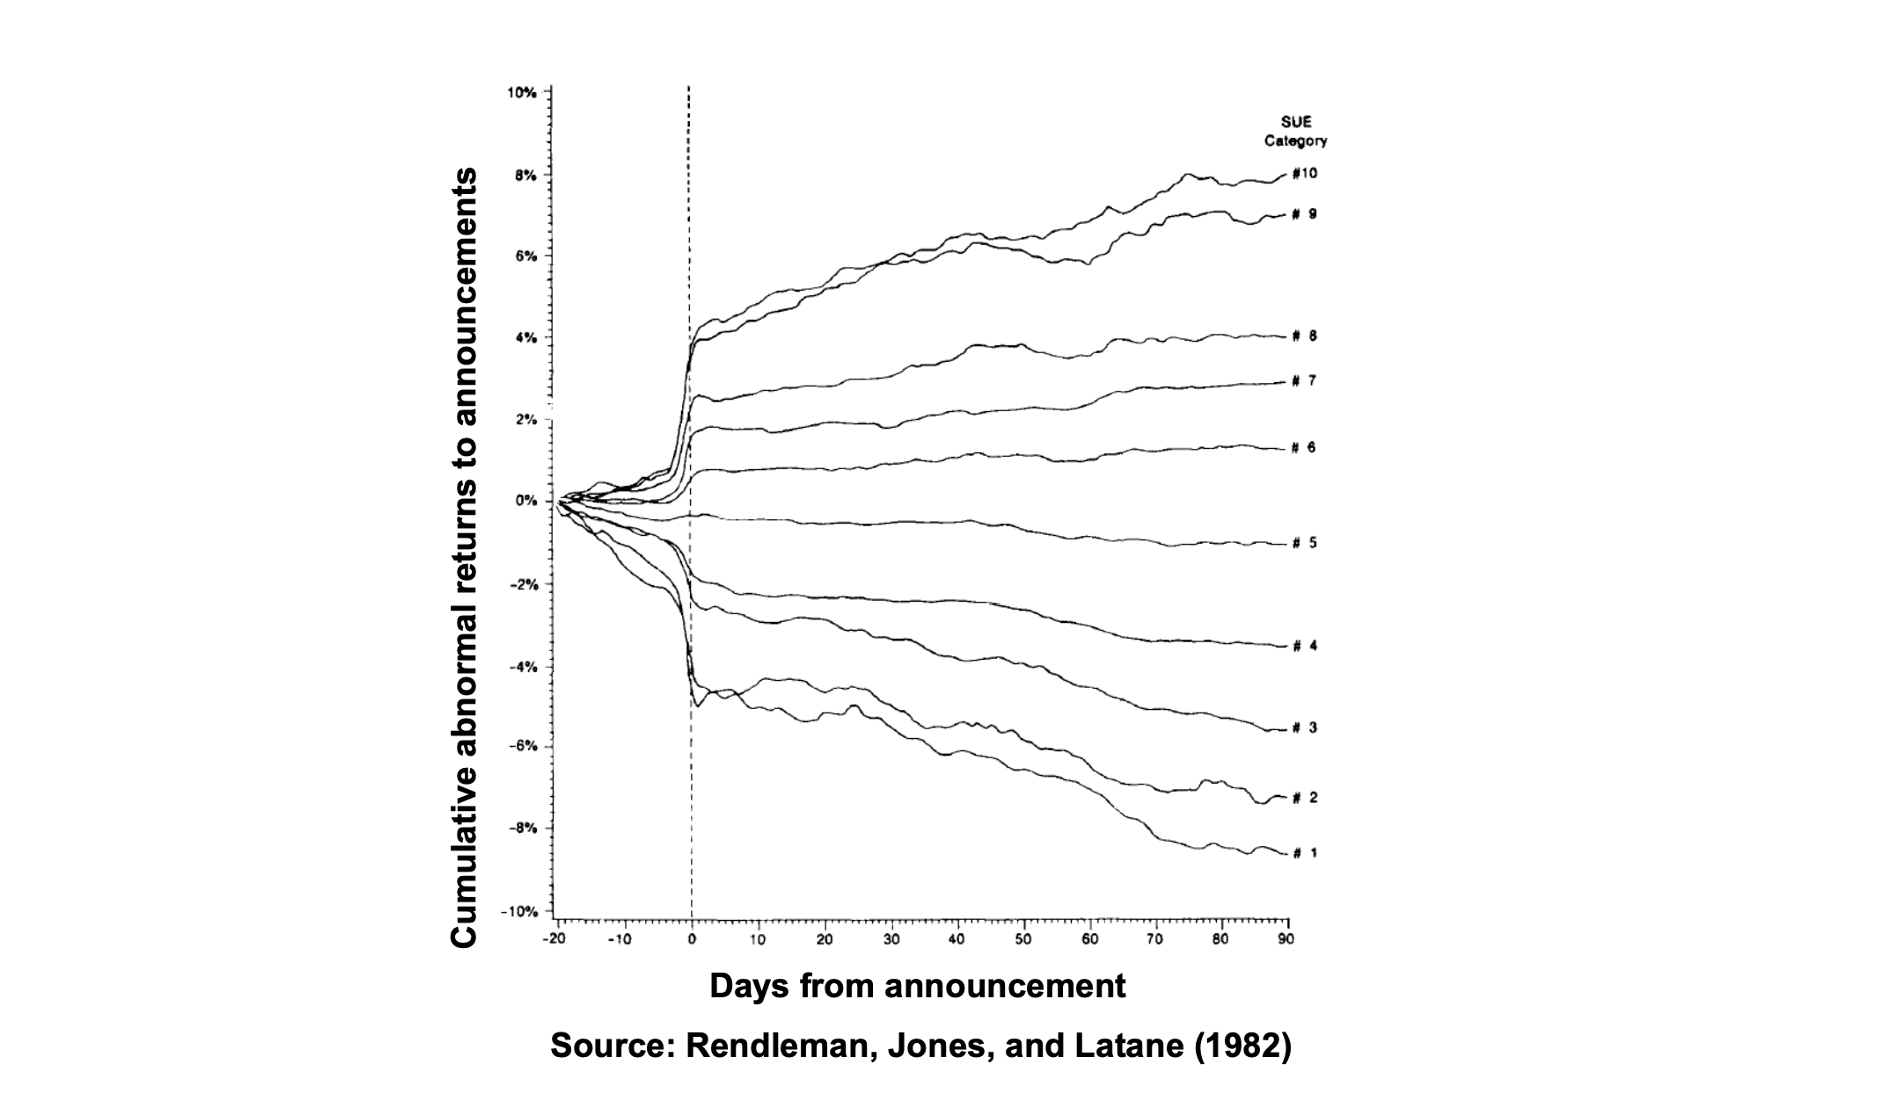

How can we conduct the event study and make a plot as above?

#### To answer the above question, we need the following data:

* the exact date on which quarterly EPS is first publicly reported;
* the realised and expected EPS (which are used to construct the earnings surprise);
* the daily stock return data (market caps, firm identifiers, daily stock returns, etc.) around the earnings announcement dates.

#### Download the dataset via this Dropbox link: https://www.dropbox.com/scl/fi/c2u3a8tzw823rd7uv1coy/crsprets_pead.csv?rlkey=8aydo7l1wq6cjod36p0m972lg&st=d3u7hapt&dl=0

in which we construct a sample of S&P500 firms between 2010 and 2019. 

---

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

### Load the dataset

In [53]:
crsprets_pead = pd.read_csv('../data/crsprets_pead.csv', index_col=0)
print(crsprets_pead.dtypes)

permno        int64
date         object
prc         float64
mcap        float64
ret         float64
mkt         float64
exret       float64
rdq1         object
leadrdq1     object
sue1        float64
sue2        float64
sue3        float64
dtype: object


* ```permno```: firm identifier;
* ```date```: trading date;
* ```prc```: stock price;
* ```mcap```: market capitalization;
* ```ret```: daily stock return;
* ```mkt```: daily return of the market index;
* ```exret```: daily excess stock return (```ret```-```mkt```);
* ```rdq1```: the date on which quarterly earnings per share are first publicly reported;
* ```leadrdq1```: next report date of quarterly earnings per share;
* ```sue3```: standardized unexpected earnings.
  $$
  \text{sue3} = \frac{\text{earnings}_t - \mathbb{E}_{t-1} \big[ \text{earnings}_t \big]}{\text{stock price}_t},
  $$
  where $\mathbb{E}_{t-1} \big[ \text{earnings}_t \big]$ is based on the analyst forecasts.

#### In the following analysis, we use ```mkt``` (returns on the S&P500 index) as the benchmark, and compute the excess returns (```exret```). 

* Intuition: The stock prices (on average) tend to increase, so the post-earnings announcement drifts can possibly be the normal drifts in stock prices due to the average upward trends. 

* In this example, we use the market index return to detrend.
   * Indeed, this is not a perfect benchmark. 

In [54]:
crsprets_pead = crsprets_pead[['permno', 'date', 'rdq1', 'exret', 'mcap', 'leadrdq1', 'sue3']]
crsprets_pead.head(10)

,permno,date,rdq1,exret,mcap,leadrdq1,sue3
318258,76076,2010-01-29,2010-02-03,0.008082,1.288430e+08,2010-05-12,0.002225
324941,76076,2010-02-01,2010-02-03,-0.003540,1.303338e+08,2010-05-12,0.002225
331617,76076,2010-02-02,2010-02-03,0.000530,1.319967e+08,2010-05-12,0.002225
338294,76076,2010-02-03,2010-02-03,0.007154,1.322834e+08,2010-05-12,0.002225
344970,76076,2010-02-04,2010-02-03,0.035883,1.327994e+08,2010-05-12,0.002225
351645,76076,2010-02-05,2010-02-03,0.020663,1.358958e+08,2010-05-12,0.002225
358319,76076,2010-02-08,2010-02-03,-0.000246,1.347433e+08,2010-05-12,0.002225
364990,76076,2010-02-09,2010-02-03,0.002759,1.369853e+08,2010-05-12,0.002225
371661,76076,2010-02-10,2010-02-03,-0.003966,1.362398e+08,2010-05-12,0.002225
378337,76076,2010-02-11,2010-02-03,-0.004931,1.370145e+08,2010-05-12,0.002225


In the above example of the stock with ```permno``` $76076$, the earnings announcement date in this fiscal quarter is ```2010-02-03```.

What we want to quantify is this stock's cumulative return from the announcement date of ```2010-02-03```, e.g., ```2010-02-04```, ```2010-02-05```, etc., before the next announcement date of ```2010-05-12``` (see column ```leadrdq1```).

Note that the standardized unexpected earnings (column ```sue3```) are positive; that is, this firm's performance beats the expectations. 

Instead of focusing on a particular firm, we want to investigate whether the firms that have positive unexpected earnings, on average, earn higher returns than those with negative unexpected earnings (in which case these firms underperform). 

## Event Study Design

#### There are several key steps:

* We need to create an indicator to denote the days after announcement (e.g., the first day after the announcement, the second day after the announcement, etc.).
    * We call this indicator event days (which equal 0, 1, 2, ...).   <br>
<br>
* On each event day, we sort the stocks based on their unexpected earnings (```sue3```).
   * The stocks in group 1 have the most postive unexpected earnings, whereas those firms in group 5 are the most disappointing firms in terms of unexpected EPS. <br>
<br>
* Finally, for the stocks in each of the five SUE groups on each event day, we compute the value-weighted portfolio return.
    * Suppose that we have $N_t$ stocks at time $t$, with stock returns $R_{i,t}$, in the portfolio.
    * Their market caps are $\text{mcap}_{i,t-1}$ at period $t-1$.
    * The value-weighted portfolio return at time $t$ is
    $$
    \frac{\sum_{i=1}^{N_t} \text{mcap}_{i,t-1} \times R_{i,t}}{\sum_{i=1}^{N_t} \text{mcap}_{i,t-1}}.
    $$

#### First, let's create a new variable, ```lagmcap```, to denote the lagged market caps of these firms ($\text{mcap}_{i,t-1}$).

In [55]:
temp = crsprets_pead.sort_values(by=['permno', 'rdq1', 'date'])
#temp['lpermno'] = temp.permno.shift(1)
#temp['lagmcap'] = np.where(temp.permno == temp.lpermno, temp.mcap.shift(1), np.nan)
temp['lagmcap'] = temp.mcap.shift(1)
temp.head()

,permno,date,rdq1,exret,mcap,leadrdq1,sue3,lagmcap
50673,10104,2010-03-22,2010-03-25,0.008825,1.281834e+08,2010-06-24,0.000406,NaN
57357,10104,2010-03-23,2010-03-25,0.009158,1.304462e+08,2010-06-24,0.000406,1.281834e+08
64042,10104,2010-03-24,2010-03-25,-0.002229,1.292918e+08,2010-06-24,0.000406,1.304462e+08
70730,10104,2010-03-25,2010-03-25,0.013307,1.306971e+08,2010-06-24,0.000406,1.292918e+08
77404,10104,2010-03-26,2010-03-25,-0.014119,1.289404e+08,2010-06-24,0.000406,1.306971e+08


#### Second, keep only the firm-day observations between the current announcement date ```rdq1``` and the next announcement date ```leadrdq1```.

In [56]:
temp = temp.loc[(temp.rdq1<=temp.date) & (temp.date<temp.leadrdq1)]
temp.head()

,permno,date,rdq1,exret,mcap,leadrdq1,sue3,lagmcap
70730,10104,2010-03-25,2010-03-25,0.013307,1.306971e+08,2010-06-24,0.000406,1.292918e+08
77404,10104,2010-03-26,2010-03-25,-0.014119,1.289404e+08,2010-06-24,0.000406,1.306971e+08
84078,10104,2010-03-29,2010-03-25,-0.011468,1.283382e+08,2010-06-24,0.000406,1.289404e+08
90751,10104,2010-03-30,2010-03-25,-0.001631,1.281876e+08,2010-06-24,0.000406,1.283382e+08
97423,10104,2010-03-31,2010-03-25,0.009422,1.290408e+08,2010-06-24,0.000406,1.281876e+08


#### Third, we create the event days (0, 1, 2, ...) and denote it as ```ncount```.

* For each stock (```permno```) and each event day (```rdq1```), we use the ```groupby``` operator;

* We next apply the cumulative count function (```cumcount```) to create the event days.

In [57]:
# create count variable within the group
temp['ncount'] = temp.groupby(['permno','rdq1']).cumcount()
temp.head(10)

,permno,date,rdq1,exret,mcap,leadrdq1,sue3,lagmcap,ncount
70730,10104,2010-03-25,2010-03-25,0.013307,1.306971e+08,2010-06-24,0.000406,1.292918e+08,0
77404,10104,2010-03-26,2010-03-25,-0.014119,1.289404e+08,2010-06-24,0.000406,1.306971e+08,1
84078,10104,2010-03-29,2010-03-25,-0.011468,1.283382e+08,2010-06-24,0.000406,1.289404e+08,2
90751,10104,2010-03-30,2010-03-25,-0.001631,1.281876e+08,2010-06-24,0.000406,1.283382e+08,3
97423,10104,2010-03-31,2010-03-25,0.009422,1.290408e+08,2010-06-24,0.000406,1.281876e+08,4
104098,10104,2010-04-01,2010-03-25,-0.018365,1.277861e+08,2010-06-24,0.000406,1.290408e+08,5
110772,10104,2010-04-05,2010-03-25,-0.004834,1.283883e+08,2010-06-24,0.000406,1.277861e+08,6
117444,10104,2010-04-06,2010-03-25,0.007652,1.296431e+08,2010-06-24,0.000406,1.283883e+08,7
124118,10104,2010-04-07,2010-03-25,0.008464,1.300446e+08,2010-06-24,0.000406,1.296431e+08,8
130802,10104,2010-04-08,2010-03-25,-0.005919,1.296431e+08,2010-06-24,0.000406,1.300446e+08,9


#### Let's keep only first 50 days after earnings annoucement dates

In [58]:
temp = temp[temp.ncount <= 50]

#### Fourth, form quintiles based on the unexpected earnings (column ```sue3```). 

##### Key step: Use the ```pd.qcut``` function to group the data into five groups on each trading day (groupby ```ncount```)

In [59]:
### Drop any duplicates in the dataset
peadrets = temp.sort_values(by=['ncount','permno','rdq1']).drop_duplicates()
peadrets

,permno,date,rdq1,exret,mcap,leadrdq1,sue3,lagmcap,ncount
70730,10104,2010-03-25,2010-03-25,0.013307,1.306971e+08,2010-06-24,0.000406,1.292918e+08,0
492303,10104,2010-06-24,2010-06-24,-0.004010,1.116777e+08,2010-09-16,0.002658,1.139897e+08,0
380925,10104,2010-09-16,2010-09-16,-0.014013,1.274876e+08,2010-12-16,0.002518,1.293979e+08,0
309763,10104,2010-12-16,2010-12-16,-0.013061,1.529368e+08,2011-03-24,0.001849,1.540483e+08,0
259686,10104,2011-03-24,2011-03-24,0.014697,1.626450e+08,2011-06-23,0.001216,1.589508e+08,0
...,...,...,...,...,...,...,...,...,...
305946,93436,2018-04-20,2018-02-07,-0.025327,4.926824e+07,2018-05-02,-0.000193,5.093858e+07,50
236153,93436,2018-07-13,2018-05-02,0.006107,5.437244e+07,2018-08-01,0.000789,5.400412e+07,50
207287,93436,2018-10-11,2018-08-01,0.000700,4.327712e+07,2018-10-24,0.001210,4.407496e+07,50
151918,93436,2019-01-08,2018-10-24,-0.009105,5.788208e+07,2019-01-30,0.010103,5.781476e+07,50


On each event day, we sort the stocks based on their unexpected earnings (```sue3```). The stocks in group 1 have the most postive unexpected earnings, whereas those firms in group 5 are the most disappointing firms in terms of unexpected EPS.

In [60]:
#peadrets['sue3r'] = peadrets.groupby('ncount')['sue3'].transform(lambda x: pd.qcut(x, 5, labels=False, duplicates='drop'))
peadrets['sue3r'] = peadrets.groupby('ncount', group_keys=False)['sue3'].apply(lambda x: pd.qcut(x, 5, labels=False, duplicates='drop'))


In [61]:
peadrets[peadrets.ncount==1].sort_values(by=['ncount','sue3r'])

,permno,date,rdq1,exret,mcap,leadrdq1,sue3,lagmcap,ncount,sue3r
42097,10104,2011-12-21,2011-12-20,-0.118583,1.295158e+08,2012-03-20,-0.000957,1.466037e+08,1,0
153859,10104,2013-03-21,2013-03-20,-0.089320,1.521543e+08,2013-06-20,-0.000292,1.684767e+08,1,0
357879,10104,2014-03-19,2014-03-18,-0.000688,1.733751e+08,2014-06-19,-0.000511,1.746794e+08,1,0
311141,10104,2014-06-20,2014-06-19,-0.041836,1.820117e+08,2014-09-18,-0.000714,1.895472e+08,1,0
256257,10104,2014-09-19,2014-09-18,-0.039752,1.773046e+08,2014-12-17,-0.000482,1.851006e+08,1,0
...,...,...,...,...,...,...,...,...,...,...
65270,93436,2012-07-26,2012-07-25,-0.043838,2.965802e+06,2012-11-05,0.002237,3.052256e+06,1,4
389070,93436,2013-05-09,2013-05-08,0.247718,8.019378e+06,2013-08-07,0.002639,6.446297e+06,1,4
314943,93436,2013-08-08,2013-08-07,0.137970,1.864015e+07,2013-11-05,0.003539,1.630223e+07,1,4
99122,93436,2016-10-27,2016-10-26,0.012738,3.057926e+07,2017-02-22,0.005538,3.031396e+07,1,4


In [62]:
### Remove the NaNs
peadrets = peadrets.loc[peadrets.sue3r.notna()]

In [63]:
peadrets

,permno,date,rdq1,exret,mcap,leadrdq1,sue3,lagmcap,ncount,sue3r
70730,10104,2010-03-25,2010-03-25,0.013307,1.306971e+08,2010-06-24,0.000406,1.292918e+08,0,2
492303,10104,2010-06-24,2010-06-24,-0.004010,1.116777e+08,2010-09-16,0.002658,1.139897e+08,0,4
380925,10104,2010-09-16,2010-09-16,-0.014013,1.274876e+08,2010-12-16,0.002518,1.293979e+08,0,4
309763,10104,2010-12-16,2010-12-16,-0.013061,1.529368e+08,2011-03-24,0.001849,1.540483e+08,0,3
259686,10104,2011-03-24,2011-03-24,0.014697,1.626450e+08,2011-06-23,0.001216,1.589508e+08,0,3
...,...,...,...,...,...,...,...,...,...,...
305946,93436,2018-04-20,2018-02-07,-0.025327,4.926824e+07,2018-05-02,-0.000193,5.093858e+07,50,0
236153,93436,2018-07-13,2018-05-02,0.006107,5.437244e+07,2018-08-01,0.000789,5.400412e+07,50,2
207287,93436,2018-10-11,2018-08-01,0.000700,4.327712e+07,2018-10-24,0.001210,4.407496e+07,50,3
151918,93436,2019-01-08,2018-10-24,-0.009105,5.788208e+07,2019-01-30,0.010103,5.781476e+07,50,4


#### Fifth, form five portfolios based on ```sue3r```.

In [64]:
#peadrets3['sue3r'] = peadrets3['sue3r'].astype(np.int64)    # convert the datatype from float64 to int64

#### We now sum the daily returns of each individual firm over the period from 1 day after the earnings announcement to the day of the next quarterly earnings announcement date!

The value-weighted portfolio return at time $t$ is
$$
\frac{\sum_{i=1}^{N_t} \text{mcap}_{i,t-1} \times R_{i,t}}{\sum_{i=1}^{N_t} \text{mcap}_{i,t-1}}.
$$

##### Calculate $\sum_{i=1}^{N_t} \text{mcap}_{i,t-1}$

In [65]:
# Calculate group weight sum;
grp_lagmcap = peadrets.groupby(['ncount','sue3r'])['lagmcap'].sum().reset_index().rename(columns={'lagmcap':'total_lagmcap'})
grp_lagmcap

,ncount,sue3r,total_lagmcap
0,0,0,9.512727e+10
1,0,1,1.550594e+11
2,0,2,1.672677e+11
3,0,3,1.374921e+11
4,0,4,9.202014e+10
...,...,...,...
250,50,0,9.215652e+10
251,50,1,1.524054e+11
252,50,2,1.632981e+11
253,50,3,1.356115e+11


##### Now merge ```grp_lagmcap``` back with ```peadrets3```, based on ```['ncount','sue3r']```.

In [66]:
peadrets3 = pd.merge(peadrets, grp_lagmcap, how='left', on=['ncount','sue3r'])
peadrets3 = peadrets3.loc[peadrets3.total_lagmcap > 0]   # ensure that the market caps are positive;
peadrets3.head(10)

,permno,date,rdq1,exret,mcap,leadrdq1,sue3,lagmcap,ncount,sue3r,total_lagmcap
0,10104,2010-03-25,2010-03-25,0.013307,1.306971e+08,2010-06-24,0.000406,1.292918e+08,0,2,1.672677e+11
1,10104,2010-06-24,2010-06-24,-0.004010,1.116777e+08,2010-09-16,0.002658,1.139897e+08,0,4,9.202014e+10
2,10104,2010-09-16,2010-09-16,-0.014013,1.274876e+08,2010-12-16,0.002518,1.293979e+08,0,4,9.202014e+10
3,10104,2010-12-16,2010-12-16,-0.013061,1.529368e+08,2011-03-24,0.001849,1.540483e+08,0,3,1.374921e+11
4,10104,2011-03-24,2011-03-24,0.014697,1.626450e+08,2011-06-23,0.001216,1.589508e+08,0,3,1.374921e+11
5,10104,2011-06-23,2011-06-23,0.010633,1.644216e+08,2011-09-20,0.001110,1.631096e+08,0,3,1.374921e+11
6,10104,2011-09-20,2011-09-20,-0.018972,1.430145e+08,2011-12-20,0.000356,1.463944e+08,0,2,1.672677e+11
7,10104,2011-12-20,2011-12-20,-0.010640,1.466037e+08,2012-03-20,-0.000957,1.438143e+08,0,0,9.512727e+10
8,10104,2012-03-20,2012-03-20,0.015932,1.497507e+08,2012-06-18,0.002051,1.480592e+08,0,3,1.374921e+11
9,10104,2012-06-18,2012-06-18,-0.023129,1.330236e+08,2012-09-20,0.001511,1.358685e+08,0,3,1.374921e+11


##### Now compute the value-weighted portfolio returns for each group ```sue3r``` on each event day:

* First, compute $\frac{\text{mcap}_{i,t-1} \times R_{i,t}}{\sum_{i=1}^{N_t} \text{mcap}_{i,t-1}}$.
* Second, sum them up: $\sum_{i=1}^{N_t} \frac{\text{mcap}_{i,t-1} \times R_{i,t}}{\sum_{i=1}^{N_t} \text{mcap}_{i,t-1}}$!

In [67]:
peadrets3['wt_ret'] = peadrets3.exret * peadrets3.lagmcap / peadrets3.total_lagmcap

In [68]:
peadsue3port = peadrets3.groupby(['ncount', 'sue3r']).wt_ret.sum().reset_index()

In [72]:
peadsue3port

,ncount,sue3r,wt_ret
0,0,0,-0.012789
1,0,1,-0.005410
2,0,2,0.003362
3,0,3,0.005263
4,0,4,0.008481
...,...,...,...
250,50,0,0.000039
251,50,1,0.000313
252,50,2,0.000156
253,50,3,0.000049


### Exercise

Can you use ```np.average``` function to compute the value-weighted portfolio returns?

In [70]:
def get_port_vw(g):
    g = g.dropna()
    return np.average(a=g.exret, weights=g.lagmcap)

In [80]:
peadsue3port2 = peadrets3.groupby(['ncount','sue3r'])[['exret','lagmcap']].apply(get_port_vw)
peadsue3port2

ncount  sue3r
0       0       -0.012789
        1       -0.005410
        2        0.003362
        3        0.005263
        4        0.008481
                   ...   
50      0        0.000039
        1        0.000313
        2        0.000156
        3        0.000049
        4        0.000341
Length: 255, dtype: float64

In [81]:

print(np.abs(peadsue3port2.values - peadsue3port.wt_ret.values).max())

1.647124623408401e-07


---

#### Sixth, set all five portfolio weighted returns on day zero (```ncount=0``` ) to be 0: We focus on the *post-earnings* announcement drifts!

In [30]:
peadsue3port['wt_ret'] = np.where(peadsue3port.ncount==0, 0, peadsue3port.wt_ret)

In [31]:
peadsue3port

,ncount,sue3r,wt_ret
0,0,0,0.000000
1,0,1,0.000000
2,0,2,0.000000
3,0,3,0.000000
4,0,4,0.000000
...,...,...,...
250,50,0,0.000039
251,50,1,0.000313
252,50,2,0.000156
253,50,3,0.000049


#### Transpose table for cumulative return calculation: Using the ```pivot_table``` method, we want the event days (```ncount```) to be the row index and ```sue3r``` to be the column index.

In [32]:
peadsue3port = peadsue3port.pivot_table(index=['ncount'], columns='sue3r')
peadsue3port    

wt_ret                                            
sue3r          0         1             2         3         4
ncount                                                      
0       0.000000  0.000000  0.000000e+00  0.000000  0.000000
1      -0.012602 -0.003341  1.123268e-03  0.005648  0.008923
2      -0.001006 -0.000322 -3.084992e-04 -0.000303 -0.000018
3      -0.000268  0.000201  3.985900e-04  0.000020  0.000737
4       0.000043  0.000345  7.621271e-04  0.000634  0.000086
5      -0.000179 -0.000008  2.583143e-04 -0.000023 -0.000372
6      -0.000228 -0.000025 -1.727837e-04 -0.000132 -0.000420
7       0.000124  0.000276  3.782739e-05  0.000242  0.000144
8      -0.000517  0.000548  2.825063e-04 -0.000072  0.000366
9       0.000016  0.000275  3.667618e-04  0.000658  0.000141
10     -0.000127 -0.000375  5.673773e-04  0.000623 -0.000014
11      0.000190  0.000132  2.381126e-04 -0.000123  0.000146
12     -0.000399  0.000034  1.284399e-04  0.000065  0.000406
13     -0.000048 -0.000286  1.599107e-04 -0.000135  0.000240
14      0.000126 -0.000085  2.521330e-04  0.000003  0.000162
15     -0.000102  0.000204 -1.468891e-04  0.000040 -0.000294
16     -0.000489  0.000086 -2.021213e-05  0.000187 -0.000152
17     -0.000315  0.000109 -7.145392e-05 -0.000359 -0.000246
18      0.000401  0.000140  1.701669e-04  0.000138  0.000438
19     -0.000223  0.000373  2.660521e-04 -0.000021  0.000191
20     -0.000325  0.000070  2.666950e-04  0.000119 -0.000505
21     -0.000334  0.000123 -4.056356e-05  0.000437 -0.000026
22     -0.000331  0.000127  5.214531e-04  0.000194 -0.000303
23     -0.000453 -0.000166 -7.253262e-04  0.000033  0.000319
24     -0.000110 -0.000224 -1.518115e-04  0.000444 -0.000713
25     -0.000258 -0.000125  4.679327e-04  0.000130  0.000476
26      0.000454  0.000117 -1.879021e-05 -0.000325 -0.000192
27     -0.000101  0.000276  3.406597e-04  0.000671 -0.000173
28      0.000288  0.000197  3.579217e-07 -0.000434  0.000504
29      0.000256  0.000244  3.078382e-04 -0.000451 -0.000552
30     -0.000571 -0.000430 -4.547622e-04  0.000356 -0.000097
31     -0.000673  0.000607  3.048946e-04  0.000677  0.000272
32     -0.000223  0.000658 -3.486729e-04 -0.000232  0.000576
33     -0.000163  0.000044 -3.338901e-05  0.000306  0.000493
34     -0.000376  0.000051 -7.303510e-05 -0.000052  0.000592
35      0.000306 -0.000181  4.385037e-04  0.000057  0.000141
36      0.000216  0.000512  7.482572e-04 -0.000158  0.000218
37     -0.000310  0.000156  3.369747e-04  0.000267  0.000337
38      0.000600  0.000111 -2.014949e-04 -0.000057  0.000544
39     -0.000179  0.000216  3.172012e-04 -0.000260  0.000031
40     -0.000418 -0.000105  1.308723e-04 -0.000358 -0.000590
41     -0.000468 -0.000323 -8.636195e-04  0.000558  0.000337
42      0.000297 -0.000013 -7.994850e-06  0.000595  0.000027
43     -0.000381  0.000225  5.459231e-05  0.000012 -0.000112
44     -0.000248 -0.000271  7.796637e-05  0.000760 -0.000110
45     -0.000012 -0.000242 -2.017256e-04  0.000511  0.000187
46     -0.000194  0.000239 -9.127720e-05  0.000027 -0.000500
47     -0.000360 -0.000307  4.517101e-04 -0.000416  0.000016
48      0.000114  0.000326  5.537055e-04  0.000101 -0.000408
49     -0.000184  0.000208  2.832441e-04 -0.000454 -0.000120
50      0.000039  0.000313  1.560946e-04  0.000049  0.000341

In [33]:
# reset column index level
#peadsue3port.columns = [col[1] for col in peadsue3port.columns]
peadsue3port = peadsue3port.reset_index()
peadsue3port

ncount    wt_ret                                            
sue3r                0         1             2         3         4
0          0  0.000000  0.000000  0.000000e+00  0.000000  0.000000
1          1 -0.012602 -0.003341  1.123268e-03  0.005648  0.008923
2          2 -0.001006 -0.000322 -3.084992e-04 -0.000303 -0.000018
3          3 -0.000268  0.000201  3.985900e-04  0.000020  0.000737
4          4  0.000043  0.000345  7.621271e-04  0.000634  0.000086
5          5 -0.000179 -0.000008  2.583143e-04 -0.000023 -0.000372
6          6 -0.000228 -0.000025 -1.727837e-04 -0.000132 -0.000420
7          7  0.000124  0.000276  3.782739e-05  0.000242  0.000144
8          8 -0.000517  0.000548  2.825063e-04 -0.000072  0.000366
9          9  0.000016  0.000275  3.667618e-04  0.000658  0.000141
10        10 -0.000127 -0.000375  5.673773e-04  0.000623 -0.000014
11        11  0.000190  0.000132  2.381126e-04 -0.000123  0.000146
12        12 -0.000399  0.000034  1.284399e-04  0.000065  0.000406
13        13 -0.000048 -0.000286  1.599107e-04 -0.000135  0.000240
14        14  0.000126 -0.000085  2.521330e-04  0.000003  0.000162
15        15 -0.000102  0.000204 -1.468891e-04  0.000040 -0.000294
16        16 -0.000489  0.000086 -2.021213e-05  0.000187 -0.000152
17        17 -0.000315  0.000109 -7.145392e-05 -0.000359 -0.000246
18        18  0.000401  0.000140  1.701669e-04  0.000138  0.000438
19        19 -0.000223  0.000373  2.660521e-04 -0.000021  0.000191
20        20 -0.000325  0.000070  2.666950e-04  0.000119 -0.000505
21        21 -0.000334  0.000123 -4.056356e-05  0.000437 -0.000026
22        22 -0.000331  0.000127  5.214531e-04  0.000194 -0.000303
23        23 -0.000453 -0.000166 -7.253262e-04  0.000033  0.000319
24        24 -0.000110 -0.000224 -1.518115e-04  0.000444 -0.000713
25        25 -0.000258 -0.000125  4.679327e-04  0.000130  0.000476
26        26  0.000454  0.000117 -1.879021e-05 -0.000325 -0.000192
27        27 -0.000101  0.000276  3.406597e-04  0.000671 -0.000173
28        28  0.000288  0.000197  3.579217e-07 -0.000434  0.000504
29        29  0.000256  0.000244  3.078382e-04 -0.000451 -0.000552
30        30 -0.000571 -0.000430 -4.547622e-04  0.000356 -0.000097
31        31 -0.000673  0.000607  3.048946e-04  0.000677  0.000272
32        32 -0.000223  0.000658 -3.486729e-04 -0.000232  0.000576
33        33 -0.000163  0.000044 -3.338901e-05  0.000306  0.000493
34        34 -0.000376  0.000051 -7.303510e-05 -0.000052  0.000592
35        35  0.000306 -0.000181  4.385037e-04  0.000057  0.000141
36        36  0.000216  0.000512  7.482572e-04 -0.000158  0.000218
37        37 -0.000310  0.000156  3.369747e-04  0.000267  0.000337
38        38  0.000600  0.000111 -2.014949e-04 -0.000057  0.000544
39        39 -0.000179  0.000216  3.172012e-04 -0.000260  0.000031
40        40 -0.000418 -0.000105  1.308723e-04 -0.000358 -0.000590
41        41 -0.000468 -0.000323 -8.636195e-04  0.000558  0.000337
42        42  0.000297 -0.000013 -7.994850e-06  0.000595  0.000027
43        43 -0.000381  0.000225  5.459231e-05  0.000012 -0.000112
44        44 -0.000248 -0.000271  7.796637e-05  0.000760 -0.000110
45        45 -0.000012 -0.000242 -2.017256e-04  0.000511  0.000187
46        46 -0.000194  0.000239 -9.127720e-05  0.000027 -0.000500
47        47 -0.000360 -0.000307  4.517101e-04 -0.000416  0.000016
48        48  0.000114  0.000326  5.537055e-04  0.000101 -0.000408
49        49 -0.000184  0.000208  2.832441e-04 -0.000454 -0.000120
50        50  0.000039  0.000313  1.560946e-04  0.000049  0.000341

In [34]:
peadsue3port.columns = ['ncount', 'sue_group1', 'sue_group2', 'sue_group3', 'sue_group4', 'sue_group5']
peadsue3port.head(10)

,ncount,sue_group1,sue_group2,sue_group3,sue_group4,sue_group5
0,0,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,-0.012602,-0.003341,0.001123,0.005648,0.008923
2,2,-0.001006,-0.000322,-0.000308,-0.000303,-0.000018
3,3,-0.000268,0.000201,0.000399,0.000020,0.000737
4,4,0.000043,0.000345,0.000762,0.000634,0.000086
5,5,-0.000179,-0.000008,0.000258,-0.000023,-0.000372
6,6,-0.000228,-0.000025,-0.000173,-0.000132,-0.000420
7,7,0.000124,0.000276,0.000038,0.000242,0.000144
8,8,-0.000517,0.000548,0.000283,-0.000072,0.000366
9,9,0.000016,0.000275,0.000367,0.000658,0.000141


#### Finally, compute cumulative excess returns for each sue group over the 50 event days

In [35]:
peadsue4port = peadsue3port[['sue_group1', 'sue_group2', 'sue_group3', 'sue_group4', 'sue_group5']].cumsum()
peadsue4port['ncount'] = peadsue3port['ncount']

In [36]:
peadsue4port

,sue_group1,sue_group2,sue_group3,sue_group4,sue_group5,ncount
0,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,-0.012602,-0.003341,0.001123,0.005648,0.008923,1
2,-0.013608,-0.003662,0.000815,0.005345,0.008905,2
3,-0.013876,-0.003461,0.001213,0.005365,0.009643,3
4,-0.013832,-0.003116,0.001975,0.006000,0.009729,4
5,-0.014011,-0.003124,0.002234,0.005976,0.009357,5
6,-0.014239,-0.003149,0.002061,0.005844,0.008937,6
7,-0.014116,-0.002873,0.002099,0.006086,0.009081,7
8,-0.014633,-0.002325,0.002381,0.006014,0.009446,8
9,-0.014617,-0.002050,0.002748,0.006672,0.009588,9


#### Plotting the output

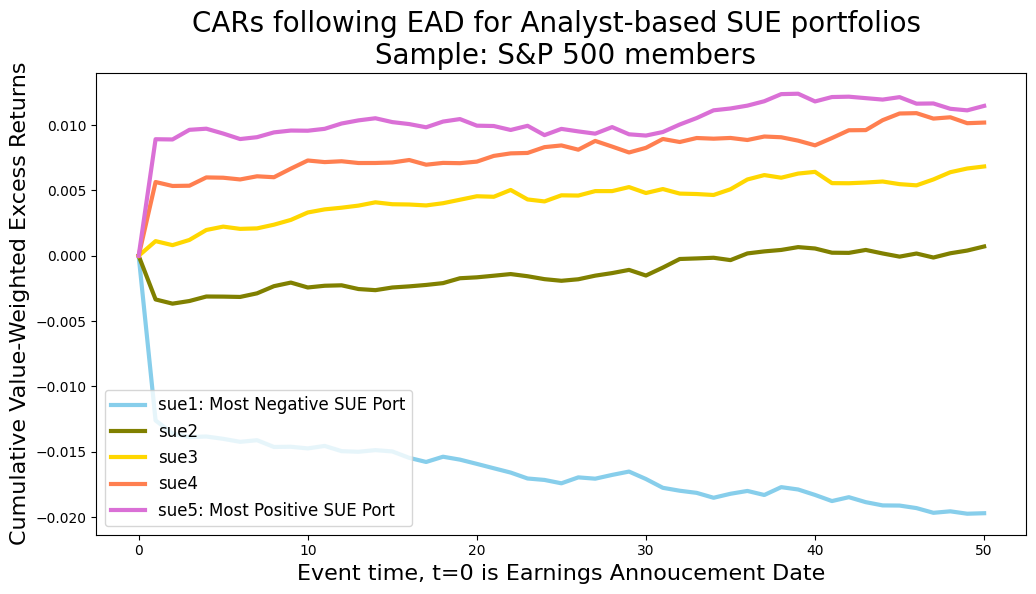

In [37]:
plt.figure(figsize=(12, 6))
plt.title('CARs following EAD for Analyst-based SUE portfolios \n Sample: S&P 500 members', fontsize=20)
plt.xlabel('Event time, t=0 is Earnings Annoucement Date', fontsize=16)
plt.ylabel('Cumulative Value-Weighted Excess Returns', fontsize=16)

plt.plot('ncount', 'sue_group1', data=peadsue4port, color='skyblue', linewidth=3, label="sue1: Most Negative SUE Port")
plt.plot('ncount', 'sue_group2', data=peadsue4port, color='olive', linewidth=3, label="sue2")
plt.plot('ncount', 'sue_group3', data=peadsue4port, color='gold', linewidth=3, label="sue3")
plt.plot('ncount', 'sue_group4', data=peadsue4port, color='coral', linewidth=3, label="sue4")
plt.plot('ncount', 'sue_group5', data=peadsue4port, color='orchid', linewidth=3, label="sue5: Most Positive SUE Port")

plt.legend(loc="best", fontsize=12)

## Conclusion

* The stocks that have more positive (or higher) unexpected earnings tend to have more positive drifts in stock prices than their counterparts many days after earnings announcement. <br>
<br>
* Can investors manipulate this phenomenon to earn abnormal returns?
   * Probably yes. Investors can long the stocks with positive unexpected earnings and short sell those with negative earnings.
   * This strategy has been shown to have good performance in a long history of time.
   * However, investors need to be careful about whether this phenomenon represents mispricing or just compensations for exposures to systematic investment risk. 

---

# END